In [57]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# **Datapreprocessing.py**


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
data = pd.read_csv('/content/drive/MyDrive/data_2024_3.csv', encoding='euc-kr')

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

print(data.head())
# Define split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Split the data into training, validation, and testing sets
train_data, temp_data = train_test_split(data, test_size=(1 - train_ratio))
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + validation_ratio))

# Save the splits to CSV files if needed
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)
print(train_data)

        관측지점              관측시간  관측온도   관측습도    관측기압  관측풍속   관측풍향  관측최대풍속  \
0      구미_산림  2024-03-05 11:40   4.1  100.0   983.7   0.5  314.7     1.0   
1     대전_주거2  2024-03-10 16:50  11.7   23.9  1016.5   0.5   78.4     1.9   
2  양구_국외(산림)  2024-03-02 17:50  -2.7   73.6   946.3   5.8  298.9     9.9   
3      양구_주거  2024-03-16 19:00  12.6   29.3   964.6   1.1  263.3     NaN   
4     충주_주거1  2024-03-19 04:10   3.5   48.2  1007.4   0.4   11.9     0.7   

   관측미세먼지  관측초미세먼지  ...  (AVOC)배관관측온도  (BVOC)관측온도  (BVOC)관측습도  (BVOC)관측기압  \
0    38.5     31.1  ...         106.0         4.1       100.0       983.8   
1    38.0     27.9  ...         103.4        11.8        23.8      1016.5   
2    28.2     16.3  ...         108.0        -2.7        73.5       946.3   
3    51.8     37.8  ...         101.9        12.6        29.0       964.6   
4    14.6     11.1  ...         107.9         3.5        46.5      1007.4   

   (BVOC)관측풍속  (BVOC)관측풍향  (BVOC)관측최대풍속  (BVOC)관측미세먼지  (BVOC)관측초미세먼지  \
0       

#**LSTM.py**

In [88]:

# 데이터 로드
train_data = pd.read_csv("train_data.csv")
#val_data = pd.read_csv("val_data.csv")
test_data = pd.read_csv("test_data.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 시계열 자료로 사용하기위해 관측시간을 활용가능한 값으로 변경
train_data['관측시간'] = pd.to_datetime(data['관측시간'])
train_data.set_index('관측시간', inplace=True)
test_data['관측시간'] = pd.to_datetime(data['관측시간'])
test_data.set_index('관측시간', inplace=True)

# 관측시간을 제대로 활용하기 위해 관측지점 라벨 인코딩
label_encoder = LabelEncoder()
train_data['관측지점'] = label_encoder.fit_transform(train_data['관측지점'])
test_data['관측지점'] = label_encoder.transform(test_data['관측지점'])

# 각각 train과 test를 알맞게 데이터와 매치, 추후 필요없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 데이터 정규화
scaler = MinMaxScaler()
X_train_scaled_data = scaler.fit_transform(X_train)
X_test_scaled_data=scaler.fit_transform(X_test)
# 시퀀스 생성
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length-1,-1])
    return np.array(X), np.array(y)

seq_length = 24 # 4시간을 기준으로 잡음
X_train, y_train = create_sequences(X_train_scaled_data, seq_length)
X_test,y_test=create_sequences(X_test_scaled_data, seq_length)

# 데이터셋 축소
test_size = int(0.01 * len(X_train))
X_train = X_train[:test_size]
y_train = y_train[:test_size]

# 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)




In [89]:
print(f"X_train shape: {X_train.shape}")  # 데이터 형태 확인
print(f"X_test shape: {X_test.shape}")  # 데이터 형태 확인
print(f"Example batch shape from DataLoader: {next(iter(train_loader))[0].shape}")  # 배치 데이터 형태 확인


X_train shape: torch.Size([3183, 24, 29])
X_test shape: torch.Size([68205, 24, 29])
Example batch shape from DataLoader: torch.Size([32, 24, 29])


In [92]:

# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

# 모델 하이퍼파라미터 설정
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 5
output_size = 1

# 모델, 손실 함수, 옵티마이저 정의
model = LSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 모델 학습
num_epochs = 30
for epoch in range(num_epochs):
    running_loss=0.0
    for X_batch, y_batch in train_loader:
        # 데이터를 GPU로 이동
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")



# 예측 함수 정의
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_outputs = test_outputs.squeeze().cpu().numpy()
    return test_outputs

# 예측후 결과 저장
predicted_values = predict(model, X_test)

#결과를 npy값으로 저장, 다음파일에서 사용가능
np.save('LSTM.npy', predicted_values)

Epoch [1/30], Loss: 0.0026
Epoch [2/30], Loss: 0.0026
Epoch [3/30], Loss: 0.0025
Epoch [4/30], Loss: 0.0026
Epoch [5/30], Loss: 0.0009
Epoch [6/30], Loss: 0.0002
Epoch [7/30], Loss: 0.0001
Epoch [8/30], Loss: 0.0001
Epoch [9/30], Loss: 0.0000
Epoch [10/30], Loss: 0.0000
Epoch [11/30], Loss: 0.0000
Epoch [12/30], Loss: 0.0000
Epoch [13/30], Loss: 0.0000
Epoch [14/30], Loss: 0.0000
Epoch [15/30], Loss: 0.0000
Epoch [16/30], Loss: 0.0000
Epoch [17/30], Loss: 0.0000
Epoch [18/30], Loss: 0.0000
Epoch [19/30], Loss: 0.0000
Epoch [20/30], Loss: 0.0000
Epoch [21/30], Loss: 0.0000
Epoch [22/30], Loss: 0.0000
Epoch [23/30], Loss: 0.0000
Epoch [24/30], Loss: 0.0000
Epoch [25/30], Loss: 0.0000
Epoch [26/30], Loss: 0.0000
Epoch [27/30], Loss: 0.0000
Epoch [28/30], Loss: 0.0000
Epoch [29/30], Loss: 0.0000
Epoch [30/30], Loss: 0.0000


#**eval.py**

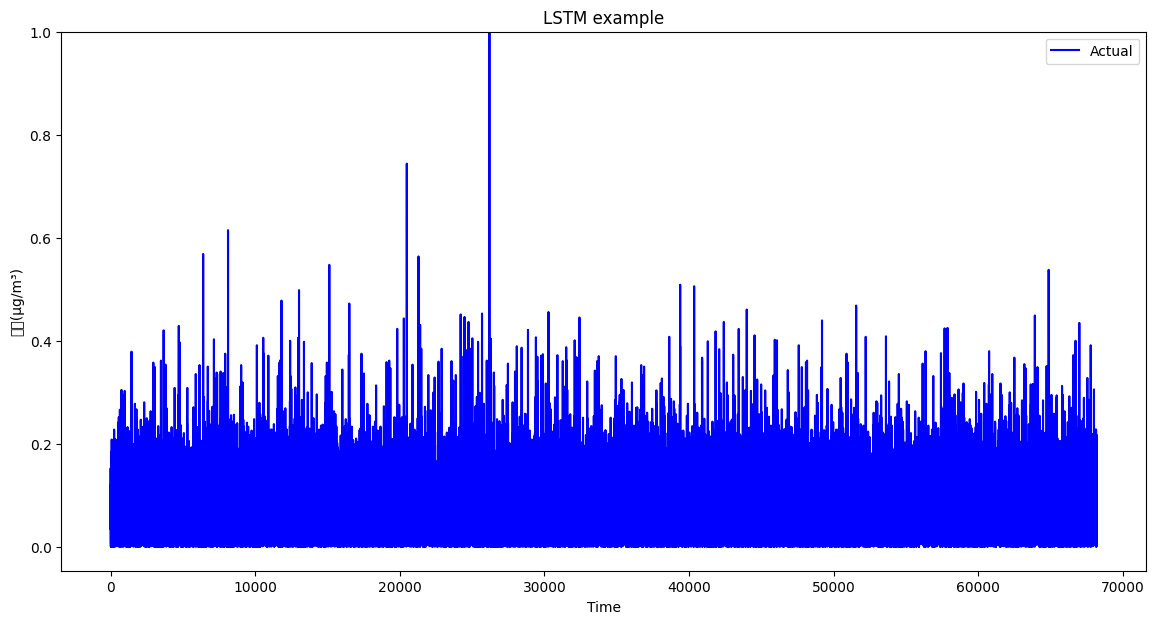

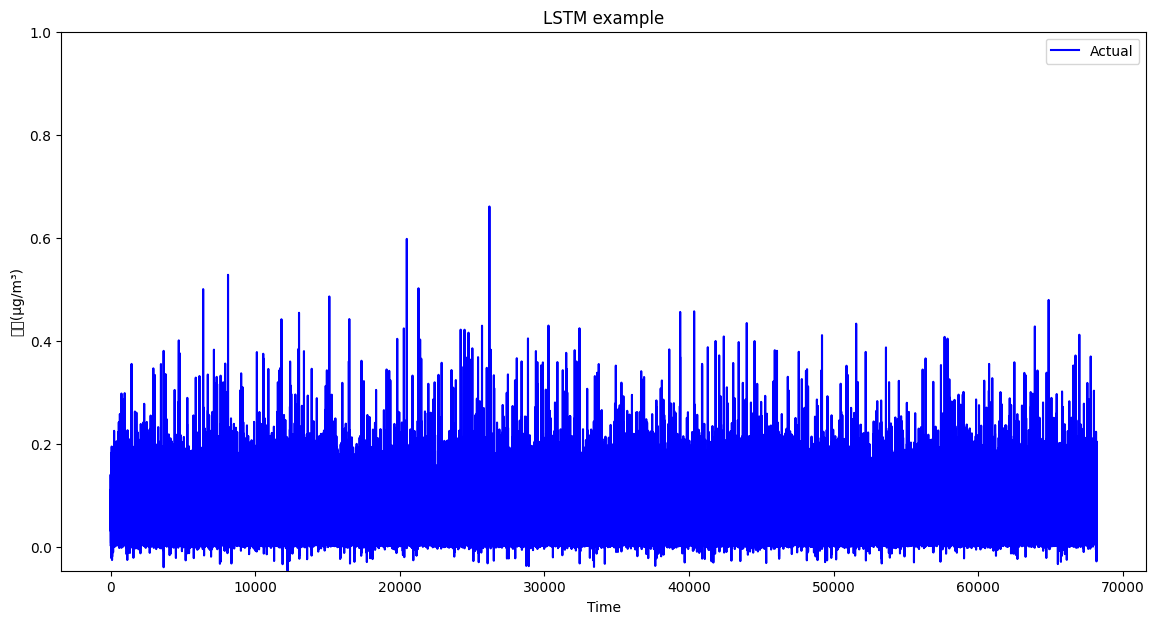

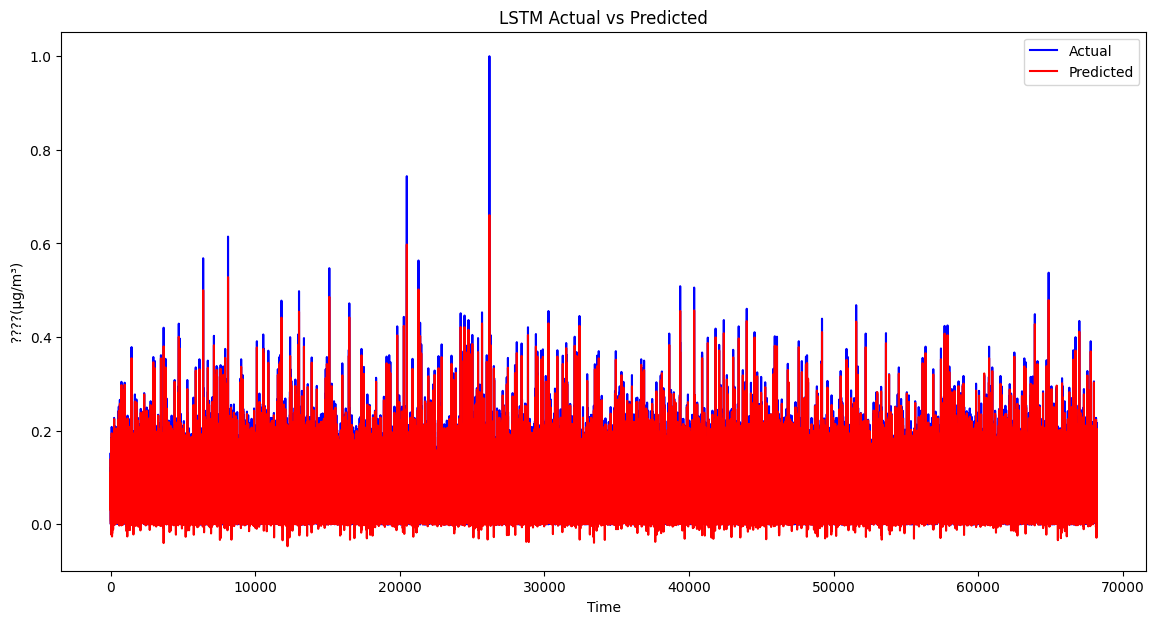

RMSE of LSTM Model : 0.0088
R-squared of LSTM Model : 0.9729


In [93]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

actual_values = y_test.cpu().numpy()
predicted_values_LSTM = np.load('LSTM.npy')

def evaluate_model(actual_values, predicted_values):

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

    # R-squared 계산
    r2 = r2_score(actual_values, predicted_values)

    return rmse, r2

def visualize_model(actual_values, predicted_values, model_name):

    time = np.arange(len(predicted_values))

    plt.figure(figsize=(14, 7))
    plt.plot(time, actual_values, label='Actual', color='blue')
    plt.plot(time, predicted_values, label='Predicted', color='red')
    plt.xlabel('Time')
    plt.ylabel('????(μg/m³)')
    plt.title(f'{model_name} Actual vs Predicted')
    plt.legend()
    plt.show()
def find_min_max(values_list):
    # 모든 값들에서 최소값과 최대값을 찾는 함수
    min_val = min(map(min, values_list))
    max_val = max(map(max, values_list))
    return min_val, max_val

# 실제값과 예측값 리스트에서 최소값과 최대값을 찾음
min_val, max_val = find_min_max([actual_values, predicted_values_LSTM])

def visualize_model_2(values, model_name, min_val, max_val):
    time = np.arange(len(values))
    plt.figure(figsize=(14, 7))
    plt.plot(time, values, label='Actual', color='blue')
    plt.xlabel('Time')
    plt.ylabel('농도(μg/m³)')
    plt.title(f'{model_name} example')
    plt.ylim(min_val, max_val)  # 여기에서 y축의 범위를 설정
    plt.legend()
    plt.show()

# 수정된 함수를 사용하여 그래프 그리기
visualize_model_2(actual_values, 'LSTM', min_val, max_val)
visualize_model_2(predicted_values_LSTM, 'LSTM', min_val, max_val)

visualize_model(actual_values, predicted_values_LSTM, 'LSTM')
print(f'RMSE of LSTM Model : {rmse_LSTM:.4f}')
print(f'R-squared of LSTM Model : {r2_LSTM:.4f}')